# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import datetime
import io
import os
import re
import string
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, InputLayer, Conv1D, Bidirectional,
                                     GRU, LSTM, BatchNormalization, Dropout, Input, Embedding, TextVectorization)
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector
from tensorflow.keras.utils import plot_model

In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-23 05:46:27--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-23 05:46:27 (82.8 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import plot_loss_curves

In [4]:
def plot_loss_curves(history):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['masked_accuracy'])
    val_accuracy = np.array(history.history['val_masked_accuracy'])

    epochs = range(len(history.history['loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

# Data Downloading

In [5]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d vaibhavkumar11/hindi-english-parallel-corpus
! unzip "/content/hindi-english-parallel-corpus.zip" -d "/content/dataset"

 96% 108M/112M [00:01<00:00, 78.3MB/s] 
100% 112M/112M [00:01<00:00, 69.2MB/s]
Archive:  /content/hindi-english-parallel-corpus.zip
  inflating: /content/dataset/hindi_english_parallel.csv  


# Data Loading

In [6]:
df = pd.read_csv("/content/dataset/hindi_english_parallel.csv", encoding='utf-8')
df.head(5)

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [7]:
df.duplicated().sum()

203501

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.isnull().sum()

hindi      4391
english      38
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
def standardization(input_data):
  input_data = str(input_data)
  no_tag = re.sub(r'<.*?>', '', input_data)
  no_url = re.sub(r'https?://\S+|www\.\S+', '', no_tag)
  return no_url

In [12]:
df['hindi'] = df['hindi'].apply(standardization)
df['english'] = df['english'].apply(standardization)

In [13]:
hindi_sentences = []
english_sentences = []
for hindi, english in zip(df['hindi'], df['english']):
  hindi = str(hindi)
  english = str(english)
  hindi_length = len(hindi.split())
  english_length = len(english.split())
  if (hindi_length >= 10) and (english_length >= 10):
   hindi_sentences.append(hindi)
   english_sentences.append(english)

In [14]:
df = pd.DataFrame(list(zip(hindi_sentences, english_sentences)), columns =['hindi', 'english'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646046 entries, 0 to 646045
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   hindi    646046 non-null  object
 1   english  646046 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [16]:
df = df.sample(50000)

In [18]:
hindi_sequence_len = [len(sentence.split()) for sentence in df['hindi']]
avg_hindi_sequence_len = np.mean(hindi_sequence_len)
english_sequence_len = [len(sentence.split()) for sentence in df['english']]
avg_english_sequence_len = np.mean(english_sequence_len)

print("Avg Hindi Sequence Length:", avg_hindi_sequence_len)
print("Avg English Sequence Length:", avg_english_sequence_len)

Avg Hindi Sequence Length: 26.65508
Avg English Sequence Length: 24.5595


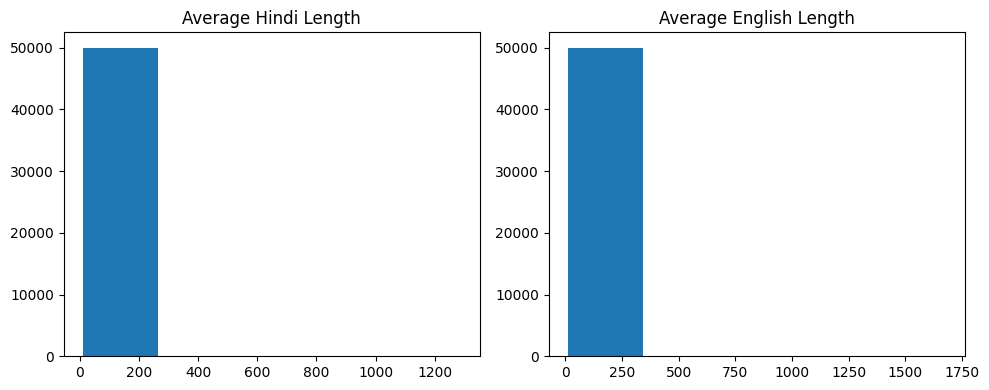

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Average Hindi Length")
plt.hist(hindi_sequence_len, bins=5)

plt.subplot(1, 2, 2)
plt.title("Average English Length")
plt.hist(english_sequence_len, bins=5)

plt.tight_layout()
plt.show()

In [20]:
output_hindi_sequence_len = int(np.percentile(hindi_sequence_len, 95))
output_english_sequence_len = int(np.percentile(english_sequence_len, 95))
print("Output Hindi Sequence Length:", output_hindi_sequence_len)
print("Output English Sequence Length:", output_english_sequence_len)

Output Hindi Sequence Length: 59
Output English Sequence Length: 53


In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train['english'], train['hindi']))
test_dataset = tf.data.Dataset.from_tensor_slices((test['english'], test['hindi']))

In [ ]:
vocab_size = 20000
english_sequence_len = 60
hindi_sequence_len = 60
embedding_dim = 128
batch_size = 64

In [ ]:
english_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                            max_tokens = vocab_size,
                                            output_mode = 'int',
                                            output_sequence_length = english_sequence_len)

In [ ]:
sample_hindi_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                                max_tokens = vocab_size,
                                                output_mode = 'int',
                                                output_sequence_length = hindi_sequence_len)

In [ ]:
english_training_data = train_dataset.map(lambda x, y:x)
english_vectorize_layer.adapt(english_training_data)

In [ ]:
english_text_vocab = english_vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(english_text_vocab)}"),
print(f"Most common words in the vocabulary: {english_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {english_text_vocab[-5:]}")

Number of words in vocabulary: 20000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'and']
Least common words in the vocabulary: ['guava', 'gsm', 'gsat14', 'gruesome', 'grub']


In [ ]:
hindi_training_data = train_dataset.map(lambda x, y:y)
sample_hindi_vectorize_layer.adapt(hindi_training_data)

In [ ]:
custom_tokens = ['starttoken', 'endtoken']
vocabulary = sample_hindi_vectorize_layer.get_vocabulary()
vocabulary_with_custom_tokens = custom_tokens + [token for token in vocabulary if token not in ['', '[UNK]']]

In [ ]:
vocab_size = 20000 + 2
hindi_vectorize_layer = TextVectorization(
    standardize = 'lower_and_strip_punctuation',
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = hindi_sequence_len)

In [ ]:
hindi_vectorize_layer.set_vocabulary(vocabulary_with_custom_tokens)

In [ ]:
hindi_text_vocab = hindi_vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(hindi_text_vocab)}"),
print(f"Most common words in the vocabulary: {hindi_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {hindi_text_vocab[-5:]}")

Number of words in vocabulary: 20002
Most common words in the vocabulary: ['', '[UNK]', 'starttoken', 'endtoken', 'के']
Least common words in the vocabulary: ['विमानक्षेत्र', 'विमर्श।', 'विभ्रम', 'विभूषित', 'विभीषिका']


In [ ]:
def selector(inputs, outputs):
  return {'input_1': inputs, 'input_2': 'starttoken ' + outputs}, outputs + ' endtoken'

In [ ]:
train_dataset = train_dataset.map(selector)
test_dataset = test_dataset.map(selector)

In [ ]:
def vectorizer(inputs, outputs):
  return {'input_1': english_vectorize_layer(inputs['input_1']),
          'input_2': hindi_vectorize_layer(inputs['input_2'])}, hindi_vectorize_layer(outputs)

In [ ]:
train_dataset = train_dataset.map(vectorizer)
test_dataset = test_dataset.map(vectorizer)

In [ ]:
for english, hindi in train_dataset.take(1):
  print(english)
  print(hindi)

{'input_1': <tf.Tensor: shape=(60,), dtype=int64, numpy=
array([ 259,  102,   43,   65,   17, 4328,    4,    6, 1492,  152,   14,
        160,   16,  276, 3320,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>, 'input_2': <tf.Tensor: shape=(60,), dtype=int64, numpy=
array([    2,    32,   150,    10, 12125,     5,  5517, 10232,   248,
          23,    25,  1177,     9,   254,     1,    10,  1210,    21,
          73,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])>}
tf.Tensor(

In [ ]:
hindi_text_vocab[2]

'starttoken'

In [ ]:
hindi_text_vocab[3]

'endtoken'

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)

In [ ]:
train_dataset

<_BatchDataset element_spec=({'input_1': TensorSpec(shape=(64, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(64, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(64, None), dtype=tf.int64, name=None))>

# Model

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, Dropout, Dense

In [ ]:
def positional_encoding(model_size, SEQUENCE_LENGTH):
  output = []
  for pos in range(SEQUENCE_LENGTH):
    PE = np.zeros((model_size))
    for i in range(model_size):
      if i%2 == 0:
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis=0))
  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(Layer):
  def __init__(self, vocab_size, d_model, sequence_length):
    super(PositionalEmbedding, self).__init__()
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.token_embeddings = Embedding(input_dim=self.vocab_size, output_dim=self.d_model)

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.d_model, self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super(PositionalEmbedding, self).get_config()
    config.update({
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'd_model': self.d_model})
    return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

In [ ]:
@tf.keras.utils.register_keras_serializable()
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
@tf.keras.utils.register_keras_serializable()
class FeedForward(Layer):
  def __init__(self, d_model, dff, dropout_rate=0.4):
    super(FeedForward, self).__init__()
    self.d_model = d_model
    self.dff = dff
    self.seq = tf.keras.Sequential([Dense(self.dff, activation='relu'),
                                    Dense(self.d_model),
                                    Dropout(dropout_rate)])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

  def get_config(self):
    config = super(FeedForward, self).get_config()
    config.update({
        'dff_layer': self.dff,
        'd_model': self.d_model})
    return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class EncoderLayer(Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.4):
    super(EncoderLayer, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff
    self.self_attention = GlobalSelfAttention(num_heads=self.num_heads, key_dim=self.d_model, dropout=dropout_rate)
    self.ffn = FeedForward(self.d_model, self.dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

  def get_config(self):
    config = super(EncoderLayer, self).get_config()
    config.update({
        'num_heads': self.num_heads,
        'dff': self.dff,
        'd_model': self.d_model,
    })
    return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Encoder(Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, sequence_length, dropout_rate=0.4):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.dff = dff
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length
    self.pos_embedding = PositionalEmbedding(vocab_size=self.vocab_size, d_model=self.d_model, sequence_length=self.sequence_length)
    self.enc_layers = [EncoderLayer(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
    self.dropout = Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x

  def get_config(self):
    config = super(Encoder, self).get_config()
    config.update({
        'num_layers': self.num_layers,
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dff': self.dff,
        'vocab_size': self.vocab_size,
        'sequence_length': self.sequence_length,
    })
    return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class DecoderLayer(Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.4):
    super(DecoderLayer, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff
    self.causal_self_attention = CausalSelfAttention(num_heads=self.num_heads, key_dim=self.d_model, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=self.num_heads, key_dim=self.d_model, dropout=dropout_rate)
    self.ffn = FeedForward(self.d_model, self.dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    x = self.ffn(x)
    return x

  def get_config(self):
    config = super(DecoderLayer, self).get_config()
    config.update({
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dff': self.dff,
    })
    return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Decoder(Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, sequence_length, dropout_rate=0.4):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.dff = dff
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length
    self.pos_embedding = PositionalEmbedding(vocab_size=self.vocab_size, d_model=self.d_model, sequence_length=self.sequence_length)
    self.dropout = Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, dropout_rate=dropout_rate) for _ in range(self.num_layers)]

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    return x

  def get_config(self):
    config = super(Decoder, self).get_config()
    config.update({
        'num_layers': self.num_layers,
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dff': self.dff,
        'vocab_size': self.vocab_size,
        'sequence_length': self.sequence_length,
        })
    return config

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.4
english_sequence_len = 60
hindi_sequence_len = 60

In [ ]:
encoder_inputs = Input(shape=(None,), dtype='int64', name='input_1')
x = Encoder(num_layers=num_layers, d_model=d_model,
            num_heads=num_heads, dff=dff,
            vocab_size=vocab_size,
            sequence_length = english_sequence_len,
            dropout_rate=dropout_rate)(encoder_inputs)
encoder_outputs = x

decoder_inputs = Input(shape=(None,), dtype='int64', name='input_2')
x = Decoder(num_layers=num_layers, d_model=d_model,
            num_heads=num_heads, dff=dff,
            vocab_size=vocab_size+2,
            sequence_length = hindi_sequence_len,
            dropout_rate=dropout_rate)(decoder_inputs, encoder_outputs)

decoder_outputs = Dense(vocab_size+2, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 encoder_3 (Encoder)         (None, 60, 128)              5199104   ['input_1[0][0]']             
                                                                                                  
 decoder_3 (Decoder)         (None, 60, 128)              7310336   ['input_2[0][0]',             
                                                                     'encoder_3[0][0]'] 

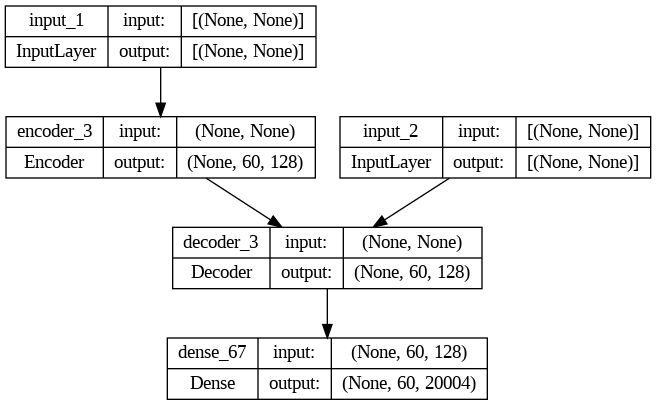

In [ ]:
plot_model(transformer, show_shapes=True)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(LearningRateSchedule):
    def __init__(self, d_model=None, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            'd_model': self.d_model.numpy(),  # Convert to a serializable type
            'warmup_steps': self.warmup_steps}

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred
  mask = label != 0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(loss = masked_loss,
                    optimizer = optimizer,
                    metrics = [masked_accuracy])

In [ ]:
history = transformer.fit(train_dataset.take(10),
                          validation_data = test_dataset.take(1),
                          epochs = 1)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 74s 976ms/step - loss: 9.9026 - masked_accuracy: 5.8241e-05 - val_loss: 9.9038 - val_masked_accuracy: 0.0000e+00


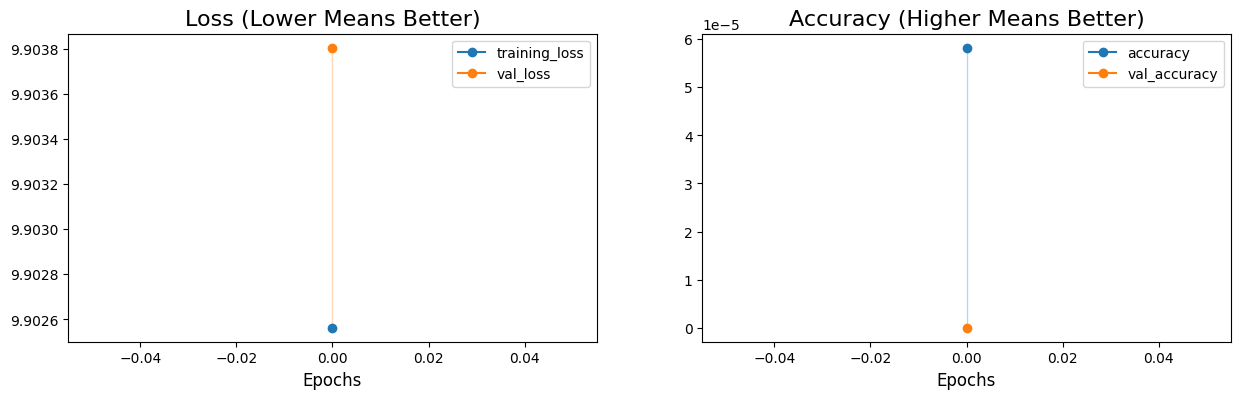

In [ ]:
plot_loss_curves(history)

# Saving and Loading Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
input_english = Input(shape=[1,], dtype='string')
output_layer = english_vectorize_layer(input_english)
english_vectorizer = Model(inputs=input_english, outputs=output_layer)

In [ ]:
english_vectorizer.save("english_vectorizer_model")
loaded_english_vectorizer = tf.keras.models.load_model("english_vectorizer_model")

In [ ]:
input_hindi = Input(shape=[1,], dtype='string')
output_layer = hindi_vectorize_layer(input_hindi)
hindi_vectorizer = Model(inputs=input_hindi, outputs=output_layer)

In [ ]:
hindi_vectorizer.save("hindi_vectorizer_model")
loaded_hindi_vectorizer = tf.keras.models.load_model("hindi_vectorizer_model")

In [ ]:
index_to_word = {x:y for x, y in zip(range(len(hindi_vectorize_layer.get_vocabulary())),
                                     hindi_vectorize_layer.get_vocabulary())}

In [ ]:
import json

filename = "index_to_word.json"
with open(filename, 'w') as file:
    json.dump(index_to_word, file)

In [ ]:
filename = "index_to_word.json"
with open(filename, 'r') as file:
    loaded_index_to_word = json.load(file)

In [ ]:
transformer.save("transformer_model")

In [ ]:
loaded_transformer = tf.keras.models.load_model("transformer_model", custom_objects={"masked_accuracy": masked_accuracy, "masked_loss": masked_loss})

In [ ]:
%cp -av /content/transformer_model /content/drive/MyDrive/Different_News_Category_Classification

# Model at inference

In [ ]:
index_to_word = {x:y for x, y in zip(range(len(hindi_vectorize_layer.get_vocabulary())),
                                     hindi_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence = english_vectorize_layer([english_sentence])
  shifted_target = 'starttoken'

  for i in range(60):
    tokenized_shifted_target = hindi_vectorize_layer([shifted_target])
    output = transformer.predict([tokenized_english_sentence, tokenized_shifted_target])
    hindi_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[hindi_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
  return shifted_target[11:]

In [ ]:
translator("Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen.")

1/1 [==============================] - 0s 31ms/step


'पसीना पसीना रुसवाई रुसवाई सौभाग्य लाइसेंस लाइसेंस रकसैक अवस्थिति अवस्थिति क़ीमत क़ीमत लाइसेंस लाइसेंस लाइसेंस छोड़ते सगे सगे लगेंगे अवस्थिति भागतः भागतः भागतः लकी अभिरुचि अभिरुचि अभिरुचि अभिरुचि सरंक्षण सरंक्षण सरंक्षण पशुबलि पशुबलि भागतः आलेखी आलेखी 1977 शत्रुदेश शत्रुदेश योद्धा योद्धा योद्धा योद्धा चौड़ाई चौड़ाई रकसैक टिकटें टिकटें टिकटें चुन टिकटें ग़नीमतें ग़नीमतें ग़नीमतें ग़नीमतें आठवीं धब्बे धब्बे जलापूर्ति जलापूर्ति'

# Model Evaluation

In [ ]:
index_to_word = {x:y for x, y in zip(range(len(hindi_vectorize_layer.get_vocabulary())),
                                     hindi_vectorize_layer.get_vocabulary())}

In [ ]:
train_data, test_data = train_test_split(test, test_size=0.3)

In [ ]:
! pip install sacrebleu

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

NLTK_BLEU_SCORE = []
SAC_BLEU_SCORE = []
smoothing = SmoothingFunction()

for english, hindi in zip(test_data['english'], test_data['hindi']):
  tokenized_english_sentence = english_vectorize_layer([english])
  shifted_target = 'starttoken'

  for i in range(60):
    tokenized_shifted_target = hindi_vectorize_layer([shifted_target])
    output = transformer.predict([tokenized_english_sentence, tokenized_shifted_target])
    hindi_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[hindi_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
  predicted_sentence = shifted_target[11:]

  bleu_score = sentence_bleu([hindi.split()], predicted_sentence.split(), smoothing_function=smoothing.method1)
  NLTK_BLEU_SCORE.append(bleu_score)

  bleu_score = sacrebleu.corpus_bleu([predicted_sentence], [[hindi]], force=True)
  SAC_BLEU_SCORE.append(bleu_score.score)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 54ms/step


In [ ]:
nltk_bleu_score = np.array(NLTK_BLEU_SCORE)
nltk_bleu_score = np.mean(nltk_bleu_score, axis=0)

sac_bleu_scores = np.array(SAC_BLEU_SCORE)
sac_bleu_scores = np.mean(sac_bleu_scores)

print("NLTK Mean BLEU Score:", nltk_bleu_score)
print("SACREBLEU Mean BLEU Score:", sac_bleu_scores)

# Hugging Face Model

In [ ]:
! pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = transformer, repo_id = "DriveMyScream/English_to_Hindi_Translation")

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/English_to_Hindi_Translation", custom_objects={"masked_accuracy": masked_accuracy, "masked_loss": masked_loss})

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence = english_vectorize_layer([english_sentence])
  shifted_target = 'starttoken'

  for i in range(60):
    tokenized_shifted_target = hindi_vectorize_layer([shifted_target])
    output = loaded_model.predict([tokenized_english_sentence, tokenized_shifted_target])
    hindi_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[hindi_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
  return shifted_target[11:]

In [ ]:
translator("Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen.")

# Tensorflow Lite

In [ ]:
import tensorflow as tf

# path = "/content/transformer_model"
# model = tf.keras.models.load_model(path, custom_objects={"masked_accuracy": masked_accuracy, "masked_loss": masked_loss})

converter = tf.lite.TFLiteConverter.from_keras_model(transformer)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "English_Hindi_Translation.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/English_Hindi_Translation.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

english_sentence = "Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen."
tokenized_english_sentence = english_vectorize_layer([english_sentence])
shifted_target = 'starttoken'
max_sequence_length = 60

for i in range(max_sequence_length):
    tokenized_shifted_target = hindi_vectorize_layer([shifted_target])
    interpreter.set_tensor(input_details[0]['index'], tokenized_english_sentence)
    interpreter.set_tensor(input_details[1]['index'], tokenized_shifted_target)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    hindi_word_index = tf.argmax(output_data, axis=-1)[0][i].numpy()
    current_word = index_to_word[hindi_word_index]
    if current_word == 'endtoken':
        break
    shifted_target += ' ' + current_word

translated_sentence = shifted_target[11:]
print(translated_sentence)

# Pretrained Hugging face Model

In [1]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#loading the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-hi")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-hi")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [3]:
def translator(text):
  # function to translate english text to hindi
  input_ids = tokenizer.encode(text, return_tensors="pt", padding=True)
  outputs = model.generate(input_ids)
  decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return decoded_text

In [4]:
#text you want translate
texts = ["I spend a few hours a day maintaining my website.",
        "Where do random thoughts come from?",
        "	I can't believe that she is older than my mother.",
        "My Mum tries to be cool by saying that she likes all the same things that I do",
        "A song can make or ruin a person’s day if they let it get to them."]

for text in texts:
  print("English Text: ", text)
  print("Hindi Translation: ", translator(text))
  print("*"*50,"\n")

English Text:  I spend a few hours a day maintaining my website.
Hindi Translation:  मैं अपनी वेबसाइट को बनाए रखने के लिए एक दिन कुछ घंटे खर्च करता हूँ.
************************************************** 

English Text:  Where do random thoughts come from?
Hindi Translation:  बेतरतीब विचार कहाँ से आते हैं?
************************************************** 

English Text:  	I can't believe that she is older than my mother.
Hindi Translation:  मैं वह मेरी माँ से बड़ा है कि विश्वास नहीं कर सकता.
************************************************** 

English Text:  My Mum tries to be cool by saying that she likes all the same things that I do
Hindi Translation:  मेरी माँ यह कहने के द्वारा शांत होने की कोशिश करती है कि वह वही काम पसंद करती है जो मैं करता हूँ
************************************************** 

English Text:  A song can make or ruin a person’s day if they let it get to them.
Hindi Translation:  एक गीत एक व्यक्‍ति के दिन को तबाह कर सकता है यदि वे उसे पाने देते हैं ।
**********